<a href="https://colab.research.google.com/github/julietlawton/image-captioning/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q mlcroissant

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time
import textwrap
import os
import random
import ast

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from PIL import Image
from mlcroissant import Dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# for coco dataset
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

ModuleNotFoundError: No module named 'fiftyone'

### Download data to disk

In [3]:
# Download annotations (captions)
!wget https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr_annotations_30k.csv

--2024-11-11 00:44:56--  https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr_annotations_30k.csv
Resolving huggingface.co (huggingface.co)... 3.165.160.12, 3.165.160.61, 3.165.160.59, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.12|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/55/8b/558bef0bef5ef96807a371a60a509b6dca1f1f70b915af0c5ee35a2c92684941/395990db603ab8bafd5c7ab2746b22058bb1e75b78b3eb56ad755931364ac137?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27flickr_annotations_30k.csv%3B+filename%3D%22flickr_annotations_30k.csv%22%3B&response-content-type=text%2Fcsv&Expires=1731545096&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMTU0NTA5Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy81NS84Yi81NThiZWYwYmVmNWVmOTY4MDdhMzcxYTYwYTUwOWI2ZGNhMWYxZjcwYjkxNWFmMGM1ZWUzNWEyYzkyNjg0OTQxLzM5NTk5MGRiNjAzYWI4YmFmZDVjN2FiMjc0NmIyMjA1OGJiMW

In [ ]:
# Download and unzip images
!wget https://huggingface.co/datasets/nlphuji/flickr30k/resolve/main/flickr30k-images.zip
!unzip flickr30k-images.zip

In [5]:
# Load annotations and image metadata into a dataframe
flickr30k_df = pd.read_csv("flickr_annotations_30k.csv", converters={"raw": ast.literal_eval})
flickr30k_df.rename(columns={"raw": "captions"}, inplace=True)
display(flickr30k_df.head())
flickr30k_df.info()

,captions,sentids,split,filename,img_id
0,[Two young guys with shaggy hair look at their...,"[0, 1, 2, 3, 4]",train,1000092795.jpg,0
1,[Several men in hard hats are operating a gian...,"[5, 6, 7, 8, 9]",train,10002456.jpg,1
2,[A child in a pink dress is climbing up a set ...,"[10, 11, 12, 13, 14]",train,1000268201.jpg,2
3,[Someone in a blue shirt and hat is standing o...,"[15, 16, 17, 18, 19]",train,1000344755.jpg,3
4,"[Two men, one in a gray shirt, one in a black ...","[20, 21, 22, 23, 24]",train,1000366164.jpg,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31014 entries, 0 to 31013
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   captions  31014 non-null  object
 1   sentids   31014 non-null  object
 2   split     31014 non-null  object
 3   filename  31014 non-null  object
 4   img_id    31014 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


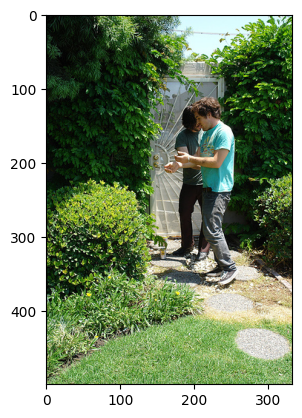

In [ ]:
img = Image.open("flickr30k-images/1000092795.jpg")
plt.imshow(img)
plt.show()

### Flickr30k/Croissant

In [ ]:
# Download Flickr30k metadata from hugging face
flickr30k_ds = Dataset(jsonld="https://huggingface.co/api/datasets/nlphuji/flickr30k/croissant")
records = flickr30k_ds.records("TEST")
records

  -  [Metadata(flickr30k)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/datePublished" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/license" is recommended, but does not exist.
  -  [Metadata(flickr30k)] Property "https://schema.org/version" is recommended, but does not exist.


Records(dataset=Dataset(jsonld='https://huggingface.co/api/datasets/nlphuji/flickr30k/croissant', operations=OperationGraph(issues=Issues(_errors=set(), _warnings={('Property "https://schema.org/version" is recommended, but does not exist.', Metadata(uuid="_:N53196e05fa654dc19aa95bed26b48f73")), ('Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.', Metadata(uuid="_:N53196e05fa654dc19aa95bed26b48f73")), ('Property "https://schema.org/license" is recommended, but does not exist.', Metadata(uuid="_:N53196e05fa654dc19aa95bed26b48f73")), ('Property "https://schema.org/datePublished" is recommended, but does not exist.', Metadata(uuid="_:N53196e05fa654dc19aa95bed26b48f73"))}), operations=<mlcroissant._src.operation_graph.base_operation.Operations object at 0x7a9df9efa2c0>), metadata=Metadata(uuid="_:N53196e05fa654dc19aa95bed26b48f73"), debug=False, mapping=None), record_set='TEST', filters=None, debug=False)

In [ ]:
# Print the names of the available record sets
record_sets = flickr30k_ds.metadata.record_sets
print(record_sets)

[RecordSet(uuid="TEST")]


In [ ]:
# Load the image metadata and captions into a dataframe
# NOTE: This does not actually load the images, just a pointer to them
flickr30k_df = pd.DataFrame(flickr30k_ds.records(record_set=record_sets[0].uuid))
display(flickr30k_df.head())
flickr30k_df.info()

,TEST/image,TEST/caption,TEST/sentids,TEST/split,TEST/img_id,TEST/filename
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'Two young guys with shaggy hair look at the...,"[b'0', b'1', b'2', b'3', b'4']",b'train',b'0',b'1000092795.jpg'
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'Several men in hard hats are operating a gi...,"[b'5', b'6', b'7', b'8', b'9']",b'train',b'1',b'10002456.jpg'
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'A child in a pink dress is climbing up a se...,"[b'10', b'11', b'12', b'13', b'14']",b'train',b'2',b'1000268201.jpg'
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,[b'Someone in a blue shirt and hat is standing...,"[b'15', b'16', b'17', b'18', b'19']",b'train',b'3',b'1000344755.jpg'
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[b'Two men, one in a gray shirt, one in a blac...","[b'20', b'21', b'22', b'23', b'24']",b'train',b'4',b'1000366164.jpg'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31014 entries, 0 to 31013
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TEST/image     31014 non-null  object
 1   TEST/caption   31014 non-null  object
 2   TEST/sentids   31014 non-null  object
 3   TEST/split     31014 non-null  object
 4   TEST/img_id    31014 non-null  object
 5   TEST/filename  31014 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


### Exploratory Data Analysis

In [ ]:
flickr30k_df["captions"] = flickr30k_df["captions"].apply(lambda x: [caption.lower() for caption in x])
flickr30k_df["captions"].head()

,captions
0,[two young guys with shaggy hair look at their...
1,[several men in hard hats are operating a gian...
2,[a child in a pink dress is climbing up a set ...
3,[someone in a blue shirt and hat is standing o...
4,"[two men, one in a gray shirt, one in a black ..."


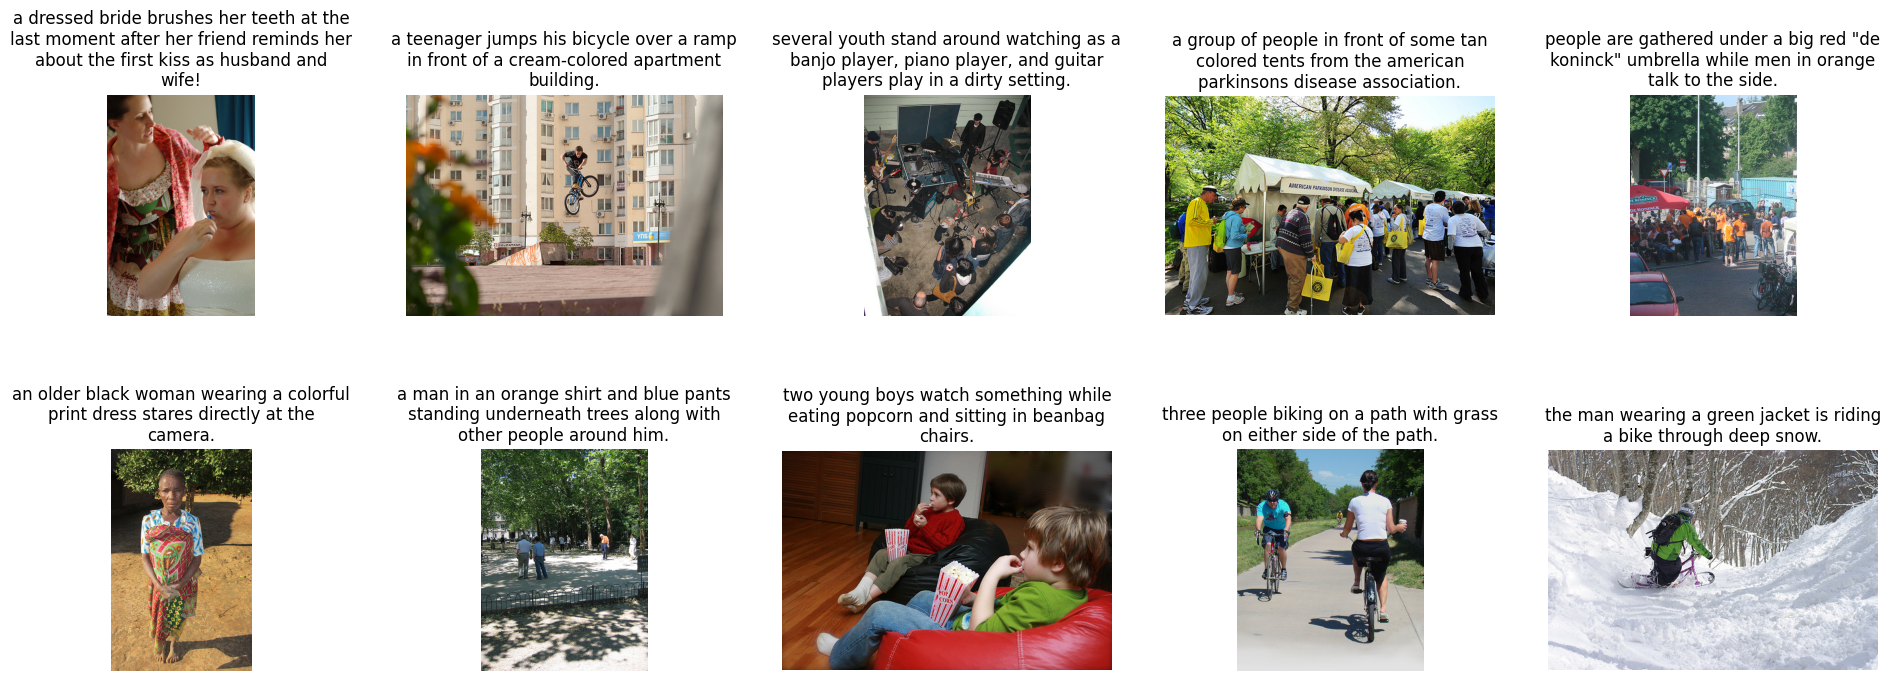

In [ ]:
# Print a random sample of 10 images and their captions
rs = flickr30k_df.sample(n=10)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

axs = axs.flatten()

for i, ax in enumerate(axs):
  img_name = rs["filename"].iloc[i]
  img = Image.open(f"flickr30k-images/{img_name}")
  ax.imshow(img)
  caption = rs["captions"].iloc[i][0]
  ax.set_title(textwrap.fill(caption, width=40))
  ax.set_axis_off()

fig.tight_layout(pad=5.0)
plt.show()

In [6]:
# Get all of the captions for EDA
all_captions = [caption for captions in flickr30k_df["captions"] for caption in captions]
all_captions[:5]

['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
 'Two young, White males are outside near many bushes.',
 'Two men in green shirts are standing in a yard.',
 'A man in a blue shirt standing in a garden.',
 'Two friends enjoy time spent together.']

Total number of captions: 155070
Mean caption length: 63.2
Median caption length: 58.0
Caption length standard dev: 26.68
Min length: 7
Q1: 45.0
Q3: 75.0
Max length: 402


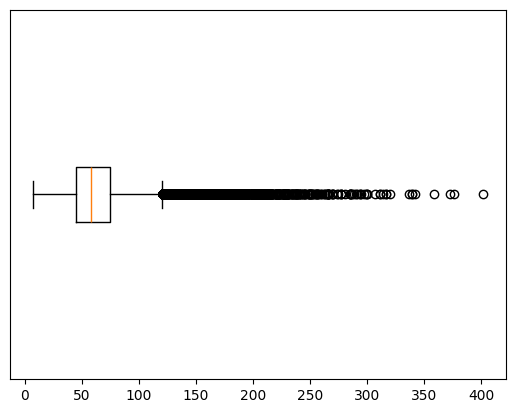

In [ ]:
# Compute descriptive statistics for the captions
print(f"Total number of captions: {len(all_captions)}")

caption_lengths = [len(caption) for caption in all_captions]

print(f"Mean caption length: {np.round(np.mean(caption_lengths), 2)}")
print(f"Median caption length: {np.median(caption_lengths)}")
print(f"Caption length standard dev: {np.round(np.std(caption_lengths), 2)}")
print(f"Min length: {np.min(caption_lengths)}")
print(f"Q1: {np.quantile(caption_lengths, 0.25)}")
print(f"Q3: {np.quantile(caption_lengths, 0.75)}")
print(f"Max length: {np.max(caption_lengths)}")

plt.boxplot(caption_lengths, vert=0)
plt.yticks([])
plt.show()

In [ ]:
# Find non-alphabetic characters in the captions
unique_chars = {char for caption in all_captions for char in caption if not char.isalpha()}
print(unique_chars)

{'-', '?', '%', '2', '$', ')', '&', ';', '#', '(', ':', '0', '"', '@', '5', '`', '!', ' ', "'", '+', '.', ',', '6', '1', '4', '=', '3', '9', '8', '7'}


In [ ]:
# Inspect instances of captions that use non-alphabetic characters
[caption for caption in all_captions if "#" in caption][:5]

['a uh football player, #15, stands near the edge of the field ready to throw the ball while his teammate blocks an opponent.',
 'a little-league baseball player, wearing a white #19 jersey, successfully hits the ball.',
 'a football player is in a red and white uniform sooners #28.',
 'a black greyhound, with a green and white jersey (#7) is running on a track.',
 'the #2 greyhound dog is running around a track.']

In [ ]:
[caption for caption in all_captions if "@" in caption]

['@ men are kneeling with their hands in front of them.',
 '@ people are cleaning windows in a dark environment.',
 '@ males wearing a black shirt and a brown shirt are looking at vegetation.']

In [ ]:
[caption for caption in all_captions if "%" in caption][:5]

['man outside in the rain promoting a 50 % off sale.',
 'an elderly man held the "college krugt diners en 3 %" sign as he stood near the brick building.',
 'a group of women are all sitting in a department store looking at some papers or booklets, and a large sign indicates 40 % off sale.',
 '2 men getting ready to cross the street under the 25 % off sign.',
 '2 rows of woman walking towards each other on the sidewalk outside of a store with a boy 50 % sign on the golden framed windows.']

In [ ]:
[caption for caption in all_captions if "=" in caption]

['two young children rif=ding sleds down the snow.',
 'people passing through an open market, while an older woman leans in front of a chilled bin on=f seafood.']

In [ ]:
[caption for caption in all_captions if "+" in caption]

['a chinese + man and younger boy in some type of worship place worshiping.',
 'an elderly woman wearing a green parka +is walking with a cane near an intersection.',
 '8+ people sitting on wood benches are viewing 8 people in brown.']

In [ ]:
[caption for caption in all_captions if "&" in caption][:5]

['grocery store employee, dressed in a red apron &amp; a baseball cap, sits on a ledge in front of the store.',
 'two ladies are cooking &amp; talking and two gentlemen are talking in the opposite site of the kitchen.',
 'a woman in a black shirt sitting behind a booth with a sign that reads "programmes &amp; ice cream."',
 'eight gentlemen are working with stone &amp; tile.',
 'a dozen workers wearing uniforms &amp; sanitation hats are working on an assembly line in a factory.']

In [ ]:
[caption for caption in all_captions if "?" in caption][:5]

['a crowd admiring modern art?',
 'the green team lifts a player up in victory after a hard game, but will the red team interfere?',
 'it takes a real man to clean a bucket with who knows what in it?',
 "that hotdog just wasn't going down right, was it the drinking or the burnt dog?",
 'people walking through a short tunnel with "where are you?" written on the wall.']

In [ ]:
[caption for caption in all_captions if "\\" in caption][:5]

[]

In [ ]:
[caption for caption in all_captions if "1" in caption][:5]

['a man in an orange shirt sings for the crowd below a sign that says lucky 13.',
 'a photographer takes a picture of a group of one girl in a pink dress and 10 boys in suits and hats.',
 'a group of 11 people in winter wear such as beanies, skiing jackets, gloves and backpacks are standing in snow paddles outside a house made of ice blocks while a person in front of the door seems to be leading them.',
 'a group of 11 smiling kids and young teens are divided into two groups, in a large, indoor swimming pool, with the back person in each group holding their arms up.',
 'in this picture we have about 11 girls posing for a picture in a pool.']

### Caption Tokenization and Encoding

In [7]:
# Will need to use a different tokenizer when using pretrained language models for the text embedding

def create_vocabulary(captions):
  unique_tokens = set()
  special_tokens = ["<START>", "<END>"]
  unique_tokens.update(special_tokens)
  for caption in captions:
    caption_tokens = word_tokenize(caption)
    unique_tokens.update(caption_tokens)
  return unique_tokens

# Test on the first caption
single_caption_vocab = create_vocabulary(all_captions[:1])
print(all_captions[:1])
print(single_caption_vocab)

['Two young guys with shaggy hair look at their hands while hanging out in the yard.']
{'at', '<END>', 'out', 'young', 'hair', 'their', 'in', 'yard', '.', 'hands', 'guys', 'Two', 'with', 'while', '<START>', 'hanging', 'the', 'shaggy', 'look'}


In [8]:
full_vocab = create_vocabulary(all_captions)
print(len(full_vocab))

23314


In [9]:
class CaptionEncoder:
  def __init__(self, vocab, seq_length):
    self.vocab = vocab
    self.vocab_size = len(vocab)
    self.seq_length = seq_length

    # ID 0 is reserved for padding
    self.token_to_id = {token: id+1 for id, token in enumerate(vocab)}
    self.id_to_token = {id: token for token, id in self.token_to_id.items()}

  def encode(self, caption):
    caption_tokens = ["<START>"] + word_tokenize(caption)
    encoding = [self.token_to_id[token] for token in caption_tokens]

    if len(encoding) < self.seq_length-1:
      padding = [0] * (self.seq_length - 1 - len(encoding))
      encoding.extend(padding)
    else:
      encoding = encoding[:self.seq_length-1]

    end_token = self.token_to_id["<END>"]
    encoding.extend([end_token])

    return encoding

  def decode(self, encoding):
    return [self.id_to_token[id] for id in encoding if id != 0]


In [10]:
encoder = CaptionEncoder(single_caption_vocab, 25)
print(encoder.token_to_id)
print(encoder.id_to_token)

{'at': 1, '<END>': 2, 'out': 3, 'young': 4, 'hair': 5, 'their': 6, 'in': 7, 'yard': 8, '.': 9, 'hands': 10, 'guys': 11, 'Two': 12, 'with': 13, 'while': 14, '<START>': 15, 'hanging': 16, 'the': 17, 'shaggy': 18, 'look': 19}
{1: 'at', 2: '<END>', 3: 'out', 4: 'young', 5: 'hair', 6: 'their', 7: 'in', 8: 'yard', 9: '.', 10: 'hands', 11: 'guys', 12: 'Two', 13: 'with', 14: 'while', 15: '<START>', 16: 'hanging', 17: 'the', 18: 'shaggy', 19: 'look'}


In [11]:
encoded_caption = encoder.encode(all_captions[0])
print(encoded_caption)
print(encoder.decode(encoded_caption))

[15, 12, 4, 11, 13, 18, 5, 19, 1, 6, 10, 14, 16, 3, 7, 17, 8, 9, 0, 0, 0, 0, 0, 0, 2]
['<START>', 'Two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard', '.', '<END>']


In [12]:
caption_encoder = CaptionEncoder(full_vocab, 120)

In [13]:
# Split data into train test and val sets
train_df = flickr30k_df[flickr30k_df["split"] == 'train']
print(train_df.info())

test_df = flickr30k_df[flickr30k_df["split"] == 'test']
print(test_df.info())

val_df = flickr30k_df[flickr30k_df["split"] == 'val']
print(val_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29000 entries, 0 to 31013
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   captions  29000 non-null  object
 1   sentids   29000 non-null  object
 2   split     29000 non-null  object
 3   filename  29000 non-null  object
 4   img_id    29000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 25 to 30943
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   captions  1000 non-null   object
 1   sentids   1000 non-null   object
 2   split     1000 non-null   object
 3   filename  1000 non-null   object
 4   img_id    1000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1014 entries, 67 to 30999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  -----

In [14]:
from concurrent.futures import ThreadPoolExecutor

In [15]:
def load_image(filename):
  img = Image.open(f"flickr30k-images/{filename}")
  img_tensor = tf.convert_to_tensor(img)
  img_tensor = tf.image.resize(img_tensor, [128, 128])
  img_tensor = img_tensor/255.0
  return img_tensor

In [16]:
data = flickr30k_df.sample(n=16)
image_files = data["filename"].values

In [17]:

test_start_time = time.time()
image_tensors = []
for file in image_files:
  img = Image.open(f"flickr30k-images/{file}")
  img_tensor = tf.convert_to_tensor(img)
  img_tensor = tf.image.resize(img_tensor, [128, 128])
  img_tensor = img_tensor/255.0
  image_tensors.append(img_tensor)

# image_captions = []
# batch_captions = data["captions"]
# for captions in batch_captions:
#   caption_idx = random.randint(0, 4)
#   caption = captions[caption_idx]

#   encoding = caption_encoder.encode(caption)
#   image_captions.append(caption)

# image_captions

test_end_time = time.time()
print(f"Test completed in {np.round((test_end_time - test_start_time), 3)} s.")

Test completed in 1.416 s.


In [18]:
test_start_time = time.time()


with ThreadPoolExecutor() as executor:
  image_tensors = list(executor.map(load_image, image_files))
test_end_time = time.time()
print(f"Test completed in {np.round((test_end_time - test_start_time), 3)} s.")

Test completed in 0.124 s.


In [19]:
# Define a data generator to load and preprocess the images and captions in
# batches to manage memory constraints
def data_generator(df, im_width, im_height, batch_size=32):
  while True:
    data = df.sample(n=batch_size)
    image_files = data["filename"]

    with ThreadPoolExecutor() as executor:
      image_tensors = list(executor.map(load_image, image_files))

    image_captions = []
    batch_captions = data["captions"]
    for captions in batch_captions:
      caption_idx = random.randint(0, 4)
      caption = captions[caption_idx]

      encoding = caption_encoder.encode(caption)
      image_captions.append(caption)

    yield np.array(image_tensors), np.array(image_captions)

In [ ]:
# Define a data generator to load and preprocess the images and captions in
# batches to manage memory constraints
def data_generator(df, im_width, im_height, batch_size=32):
  while True:
    data = df.sample(n=batch_size)
    image_files = data["filename"]

    image_tensors = []
    for file in image_files:
      img = Image.open(f"flickr30k-images/{file}")
      img_tensor = tf.convert_to_tensor(img)
      img_tensor = tf.image.resize(img_tensor, [im_width, im_height])
      img_tensor = img_tensor/255.0
      image_tensors.append(img_tensor)

    image_captions = []
    batch_captions = data["captions"]
    for captions in batch_captions:
      caption_idx = random.randint(0, 4)
      caption = captions[caption_idx]

      encoding = caption_encoder.encode(caption)
      image_captions.append(caption)

    yield np.array(image_tensors), np.array(image_captions)

In [20]:
images, captions = next(data_generator(train_df, 128, 128, batch_size=16))

A fisherman has his foot caught in his net.


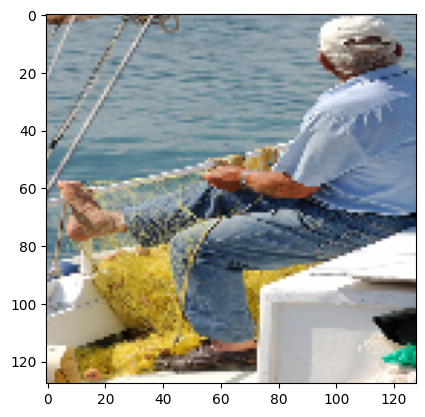

In [21]:
print(captions[0])
plt.imshow(images[0])
plt.show()

In [22]:
# Simulate a run of 10 epochs to test that the data generator will run through
# all of the images without crashing
batch_size = 64
batches_per_epoch = int(np.ceil(len(train_df)/batch_size))
num_epochs = 5

train_generator = data_generator(train_df, 224, 224, batch_size=batch_size)

test_start_time = time.time()
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1}/{num_epochs}")
  print("Generating batches...")
  epoch_start_time = time.time()

  for batch_idx in range(batches_per_epoch):
    batch = next(train_generator)

  epoch_end_time = time.time()
  print(f"Completed in {np.round((epoch_end_time - epoch_start_time), 3)} s")

test_end_time = time.time()
print(f"Test completed in {np.round((test_end_time - test_start_time), 3)} s.")

Epoch 1/5
Generating batches...
Completed in 157.652 s
Epoch 2/5
Generating batches...
Completed in 150.59 s
Epoch 3/5
Generating batches...
Completed in 155.533 s
Epoch 4/5
Generating batches...
Completed in 151.222 s
Epoch 5/5
Generating batches...
Completed in 154.266 s
Test completed in 769.267 s.


In [23]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, df, im_width, im_height, batch_size=32, shuffle=True):
    self.data = df
    self.im_width = im_width
    self.im_height = im_height
    self.batch_size = batch_size
    self.shuffle = shuffle

  def __getitem__(self, idx):
    low = idx * self.batch_size
    high = min(low + self.batch_size, len(self.data))
    batch = self.data[low:high]

    image_files = batch["filename"]
    image_tensors = []
    for file in image_files:
      img = Image.open(f"flickr30k-images/{file}")
      img_tensor = tf.convert_to_tensor(img)
      img_tensor = tf.image.resize(img_tensor, [self.im_width, self.im_height])
      img_tensor = img_tensor/255.0
      image_tensors.append(img_tensor)

    image_captions = []
    batch_captions = batch["captions"]
    for captions in batch_captions:
      caption_idx = random.randint(0, 4)
      caption = captions[caption_idx]
      encoding = caption_encoder.encode(caption)
      image_captions.append(encoding)

    return np.array(image_tensors), np.array(image_captions)

  def __len__(self):
    return int(np.ceil(len(self.data) / float(self.batch_size)))

  def on_epoch_end(self):
    if self.shuffle:
      self.data = self.data.sample(frac=1).reset_index(drop=True)

In [24]:
train_generator = DataGenerator(train_df, 224, 224, batch_size=64)

In [25]:
len(train_generator)

454

In [26]:
img_batch, caption_batch = train_generator[0]
print(img_batch.shape)
print(caption_batch.shape)

(64, 224, 224, 3)
(64, 120)


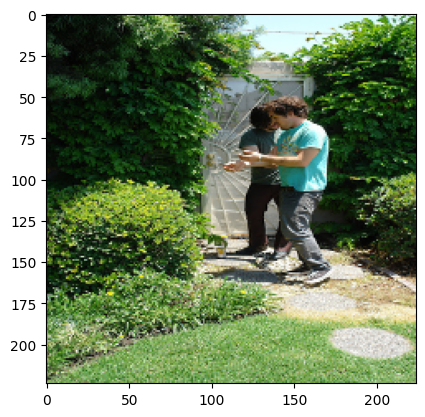

In [27]:
print(caption_batch[0])
print(caption_encoder.decode(caption_batch[0]))
plt.imshow(img_batch[0])
plt.show()

In [ ]:
np.ceil(len(train_df)/64)

454.0

In [ ]:
next(data_generator_from_croissant(train_df, 224, 224, batch_size=64)).shape

In [ ]:
# plt.imshow(next(data_generator_from_croissant(train_df, 128, 128, batch_size=64))[0])

In [ ]:
(test_end_time - test_start_time)/60

## Models


### CNN + GPT2

In [ ]:
# !pip install -q --upgrade keras-hub
# !pip install -q --upgrade keras


In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, GlobalAveragePooling2D, Attention
from tensorflow.keras.models import Model
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer


In [29]:
# Load GPT-2 model and tokenizer
gpt2_model = TFGPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
caption = caption_batch[0]
decode_batch_caption = caption_encoder.decode(caption_batch[0])
print(decode_batch_caption)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
gpt_encoded_caption = tokenizer.encode(decode_batch_caption, max_length=120, padding='max_length', truncation=True)
print(gpt_encoded_caption)
print(len(gpt_encoded_caption))

['<START>', 'Two', 'men', 'in', 'green', 'shirts', 'are', 'standing', 'in', 'a', 'yard', '.', '<END>']
[50256, 7571, 3653, 259, 14809, 23231, 533, 5646, 259, 64, 9413, 13, 50256, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257]
120


In [140]:
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, vocab_size, max_caption_length=120, cnn_input_shape=(224, 224, 3)):
        super(ImageCaptioningModel, self).__init__()

        # Load the pre-trained GPT-2 model
        self.gpt2_model = TFGPT2LMHeadModel.from_pretrained("gpt2")
        for layer in self.gpt2_model.layers:
            layer.trainable = True  # Optionally freeze GPT-2 layers

        # Define the CNN for image feature extraction
        self.image_input = Input(shape=cnn_input_shape, name="image_input")
        self.caption_input = Input(shape=(max_caption_length,), dtype=tf.int32, name="caption_input")


        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")
        self.pool2 = tf.keras.layers.GlobalAveragePooling2D()
        self.dense_cnn = Dense(256, activation="relu")
        self.dropout_cnn = Dropout(0.5)

        # Projection to GPT-2 embedding space
        self.image_projection = Dense(50257, activation="relu")
        self.caption_projection = Dense(50257, activation="relu")


        # Add a dense layer to project GPT-2 outputs to match the CNN feature dimension
        # self.caption_projection = Dense(256, activation="relu")

        # Define dense layers for combining CNN and GPT-2 features
        self.concat = Concatenate(axis=1)
        self.dense_combined = Dense(256, activation="relu")
        self.dropout_combined = Dropout(0.5)
        self.output_layer = Dense(vocab_size, activation="softmax")

    def call(self, inputs):
        # Split inputs into image and caption parts
        image, caption = inputs

        # CNN forward pass
        x = self.conv1(image)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        image_features = self.dense_cnn(x)
        image_features = self.dropout_cnn(image_features)

        print('image features after cnn', image_features.shape)
        print('caption original shape', caption.shape)
        # Project image features to match GPT-2 embedding size
        image_features = self.image_projection(image_features)

        # Pass caption through GPT-2 model
        gpt2_outputs = self.gpt2_model(caption)
        print(type(gpt2_outputs))
        caption_logits = gpt2_outputs.logits
        print("caption logit shape", caption_logits.shape)

        caption_features = Dense(256, activation="relu")(caption_logits)
        caption_features = tf.reduce_mean(caption_features, axis=1)  # (64, 256)
        print("after caption features Dense 256 and reduce mean - img shape: ", image_features.shape, "caption shape", caption_features.shape)

        combined_features = self.concat([image_features, caption_features])  # (64, 512)
        print("originally combined features", combined_features.shape)
        # Process combined features with a dense layer
        combined_features = self.dense_combined(combined_features)
        combined_features = self.dropout_combined(combined_features)
        print("after dense and dropout combined features", combined_features.shape)
        # Output prediction for each word in the sequence
        output = self.output_layer(combined_features)
        return output

In [141]:
# Set vocabulary size and other hyperparameters
vocab_size = tokenizer.vocab_size
max_caption_length = 120

# Instantiate and compile the model
model = ImageCaptioningModel(vocab_size=vocab_size, max_caption_length=max_caption_length)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [130]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [142]:
# 4. Invoke the model
input_data = (img_batch, caption_batch)
print("img shape:", input_data[0].shape, "caption shape", input_data[1].shape)

predictions = model(input_data)
print(predictions.shape)
print(predictions[0])

# Decode the full sequence of indices to get the generated caption for each image
predicted_captions = []
for sequence in predictions:
    # Decode the full sequence of word indices into a single caption string
    caption = tokenizer.decode(sequence, skip_special_tokens=True)  # Skip special tokens like padding
    predicted_captions.append(caption)

img shape: (64, 224, 224, 3) caption shape (64, 120)
image features after cnn (64, 256)
caption original shape (64, 120)
<class 'transformers.modeling_tf_outputs.TFCausalLMOutputWithCrossAttentions'>
caption logit shape (64, 120, 50257)
after caption features Dense 256 and reduce mean - img shape:  (64, 50257) caption shape (64, 256)
originally combined features (64, 50513)
after dense and dropout combined features (64, 256)
image features after cnn (64, 256)
caption original shape (64, 120)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'image_captioning_model_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


<class 'transformers.modeling_tf_outputs.TFCausalLMOutputWithCrossAttentions'>
caption logit shape (64, 120, 50257)
after caption features Dense 256 and reduce mean - img shape:  (64, 50257) caption shape (64, 256)
originally combined features (64, 50513)
after dense and dropout combined features (64, 256)
(64, 50257)
tf.Tensor(
[1.3851303e-06 4.9406035e-06 1.9392479e-05 ... 3.3863493e-05 1.1885997e-05
 6.5515314e-06], shape=(50257,), dtype=float32)


In [132]:
print(predictions[1])
print(predicted_captions[1])

tf.Tensor(
[1.2256218e-05 2.0172381e-05 7.4289951e-06 ... 2.9406901e-05 5.2711648e-06
 1.3736330e-06], shape=(50257,), dtype=float32)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [123]:
# Plot the images with their captions
num_samples = 5
plt.figure(figsize=(15, 6))
for i in range(min(num_samples, len(img_batch))):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img_batch[i])
    plt.axis('off')
    plt.title(predicted_captions[i], wrap=True)

plt.show()

ValueError: Image size of 333934x242 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x600 with 5 Axes>

In [51]:
# Decode the predicted token indices to words (excluding padding tokens)
captions_batch_decoded = []

# Iterate over the batch
for caption in caption_batch:
    # Remove padding (usually token 0 is used for padding)
    caption = [token for token in caption if token != tokenizer.pad_token_id]

    # Decode the tokens back to text (ignore special tokens like [CLS], [SEP], or padding)
    decoded_caption = caption_encoder.decode(caption)

    captions_batch_decoded.append(' '.join(decoded_caption))

print(captions_batch_decoded[0])
print(type(captions_batch_decoded[0]))

<START> Two men in green shirts are standing in a yard . <END>
<class 'str'>


# Appendix

In [ ]:
!pip install -q fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.1/943.1 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.1 MB/s eta 0:00:00

In [ ]:
#Preprocess Captions:
def preprocess_captions(flickr30k_df):
  for index, row in flickr30k_df.iterrows():
    caption = str(row["TEST/caption"][0])
    #remove b' in each caption
    caption = caption[2:]
    #Convert Caption to lowercase
    caption = caption.lower()

    # Delete digits and special chars
    caption = caption.replace("[^A-Za-z]", "")

    #Remove extra spaces
    caption = caption.replace("\s+", " ")
    #remove all single letter words in caption
    caption = "<start> " + " ".join([word for word in caption.split() if len(word)>1]) + " <end>"
    flickr30k_df.at[index, "TEST/preprocessed_caption"] = caption

In [ ]:
preprocess_captions(flickr30k_df)

In [ ]:
# Using coco dataset with FiftyOne
# https://medium.com/voxel51/the-coco-dataset-best-practices-for-downloading-visualization-and-evaluation-68a3d7e97fb7

feature_classes = ["person", "car", "truck"]
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=feature_classes,
    max_samples=100,
)

session = fo.launch_app(dataset)

In [ ]:
# dataset.get_field_schema()
field_names = list(dataset.get_field_schema().keys())
print(field_names)
display(dataset.first())

In [ ]:
coco_ds = dataset.take(100, seed=222)
print(coco_ds)

In [ ]:
print(coco_ds.first().field_names)

In [ ]:
rand_samples_ds.distinct("ground_truth.detections.label")


In [ ]:
# Load model from zoo and apply it to dataset
model = foz.load_zoo_model("faster-rcnn-resnet50-fpn-coco-torch")
dataset.apply_model(model, label_field="predictions")

# Evaluate `predictions` w.r.t. labels in `ground_truth` field
results = dataset.evaluate_detections(
    "predictions", gt_field="ground_truth", eval_key="eval", compute_mAP=True,
)

# Print the mAP
print("mean Average Precision", results.mAP())
session = fo.launch_app(dataset)

# Convert to evaluation patches
eval_patches = dataset.to_evaluation_patches("eval")
# View patches in the App
session.view = eval_patches

In [ ]:
! cd